### Mini Project | Unsupervised Learning | Report

Submitted by 
* Paraneetharan M
* Karthikeyan
* Karthik Reddy
* Vishnu

### Objective
The aim of this Mini-project is to group the given STL-10 image dataset using Unsupervised Learning Techniques and document the findings. Following are the high level expectation from this project work.

* Identify different types of features to represent every data point - We have used 3 different representation of the STL-10 train dataset namely RGB colour vectors, L*a*b colour space vectors, Gray scale vectors to represent the images to apply USL clustering techniques.
* Use PCA for transforming the data from high dimensions to a reasonably low dimension.
* Cluster using K-means Classification 
* Rename the clusters with class names for Purity Check
* Calculate Comfort Matrix and Accuracy.


### 1. Import the Image Dataset

In [1]:
# Import the python code to process images
import stl10_input as stl

sys.version_info(major=3, minor=6, micro=6, releaselevel='final', serial=0)


In [2]:
import numpy as np
import pandas as pd
import pickle

# importing ploting libraries
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

Lets try experiment with 
* RGB color vectors
* L\*a*b color vectors
* Gray scale vectors

In [3]:
# Path to X_test, y_test
X_test_dir = './data/stl10_binary/test_X.bin'
y_test_dir = './data/stl10_binary/test_y.bin'

In [4]:
# get train & test image datasets
X_train = stl.read_all_images(stl.DATA_PATH)
X_test = stl.read_all_images(X_test_dir)
print(X_train.shape)
print(X_test.shape)

(5000, 96, 96, 3)
(8000, 96, 96, 3)


In [5]:
# get train & test labels
y_train = stl.read_labels(stl.LABEL_PATH)
y_test = stl.read_labels(y_test_dir)
print(y_train.shape)
print(y_test.shape)

(5000,)
(8000,)


(96, 96, 3)


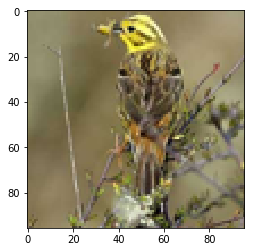

In [6]:
# Print one image to test
print(X_train[0,:].shape)
plt.imshow(X_train[0,:])

In [8]:
# Lets print one image in each class
unique_classes = set(y_train)

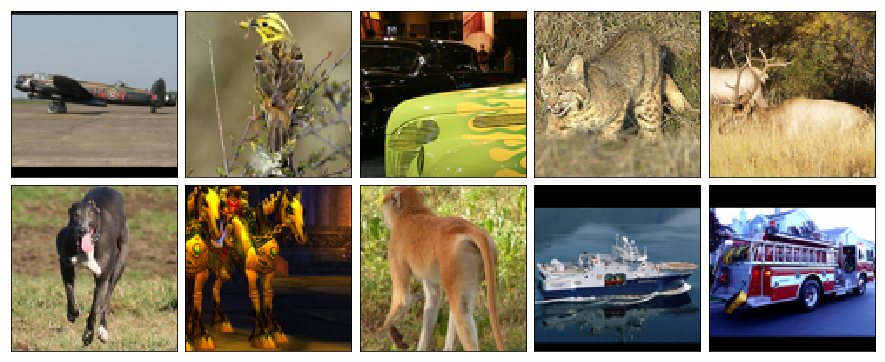

In [34]:
# Initialize the figure
# Lets get the index of first label in each class and print the corresponding figure
fig = plt.figure(figsize=(12, 12))

# Adjust the subplots 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

i = 1

for cl in unique_classes:
    ax = fig.add_subplot(5, 5, i, xticks=[], yticks=[])
    ax.imshow(X_train[np.where(y_train == cl)[0][0],:])
    
    # Don't include axes
    # plt.axis('off')
    i+=1
# Show the plot
plt.show()

### 2. Extract the Features
#### Lets prepare 2D dataset for RGB, LAB and GRAY scale images

### RGB

In [4]:
# RGB Train Dataset
t, x, y, z = X_train.shape
X_train_RGB = X_train.reshape(t, x*y*z)
X_train_RGB.shape

(5000, 27648)

## L\*a*b

In [5]:
# L*a*b Dataset
from skimage import io, color
X_train_LAB_space = color.rgb2lab(X_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


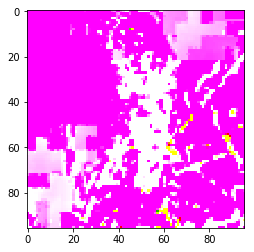

In [6]:
# Print one image to test
plt.imshow(X_train_LAB_space[0,:])

Since the color information exists in the 'a*b*' color space, lets extract only those 2 values.

In [7]:
# Lets select only a* and b* from L*a*b* space
X_train_LAB_ab = X_train_LAB_space[:,:,:,1:3]
X_train_LAB_ab.shape

(5000, 96, 96, 2)

In [8]:
# Reshape *a*b dataset
t, x, y, z = X_train_LAB_ab.shape
X_train_LAB = X_train_LAB_ab.reshape(t, x*y*z)
X_train_LAB.shape

(5000, 18432)

In [9]:
# Function to convert RGB to GRAY
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [10]:
X_train_gray = rgb2gray(X_train)

In [11]:
X_train_gray.shape

(5000, 96, 96)

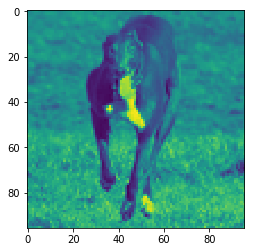

In [12]:
# Print one image to test
plt.imshow(X_train_gray[1,:])

In [13]:
# Reshape the images dataset into 2d for clustering
t, x, y = X_train_gray.shape
X_train_gray_2d = X_train_gray.reshape(t, x*y)
print(X_train_gray_2d.shape)

(5000, 9216)


### KMeans Clustering - with RGB pixel vector

In [14]:
from sklearn.cluster import KMeans

In [57]:
# This can be skipped because the model is already available in a pickle file below.
km_model_RGB = KMeans(n_clusters = 25)

In [58]:
km_model_RGB.fit(X_train_RGB)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=25, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [237]:
# Save the model to disk
pkl_km_RGB = "pkl_km_RGB.pkl" 
with open(pkl_km_RGB, 'wb') as f:  
    pickle.dump(km_model_RGB, f)

In [16]:
# Load the model from file
pkl_km_RGB = "pkl_km_RGB.pkl" 
with open(pkl_km_RGB, 'rb') as f:
    km_model_RGB = pickle.load(f)

In [240]:
km_RGB_centers = km_model_RGB.cluster_centers_
km_RGB_labels = km_model_RGB.predict(X_train_RGB)
km_RGB_labels

array([8, 8, 7, ..., 8, 8, 6], dtype=int32)

In [46]:
# This function takes the list of model labels & Image source
# And prints first 100 images in each cluster
def printClusterImages(model_labels, image_source):
    
    tot_count = 0

    for i in np.unique(model_labels):
        count = 0
        pos = 0
        vals = []
        for val in model_labels:
            if val == i:
                count = count + 1
                vals.append(pos)
            pos = pos + 1
        tot_count = tot_count + count
        print('Cluster No: ', i)
        print('=================')
        print('No of Items in this cluster: ', count)

        # Creates blank canvas
        fig = plt.figure(figsize=(10, 10))
        # Adjust the subplots 
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

        # For each of the 100 images
        j = 0
        for i in vals[:100]:
            j = j + 1
            # Initialize the subplots: add a subplot in the grid of 10 by 10, at the i+1-th position
            ax = fig.add_subplot(10, 10, j, xticks=[], yticks=[])
            # Display an image at the i-th position
            ax.imshow(image_source[i,])

        # Show the plot
        plt.show()


    print('Total count: ', tot_count)

### Lets Label the clusters
Here it is necessary to change the class labels because the K-Means model is unsupervised it did not know which label (class 0, 1 to 10 ) to assign to each class (cat, dog etc). To do this it is necessary to print and see what kind of images are grouped in every cluster and name the cluster based on the most common object in that.

<b> Actual classes from STL-10 dataset: </b>
10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.

In [ ]:
printClusterImages(km_model_RGB.labels_, X_train)

Based on the above lets decide the class as given below. <br>
0 - ship, 1 - car, 2 - bird, 3 - horse, 4 - car, 5 - cat, 6 - deer , 7 - dog ,8 - monkey ,9 - airplane

In [48]:
# Lets relable the class nos
km_RGB_labels_renamed = np.choose(km_model_RGB.labels_, [9,3,2,7,3,4,5,6,8,1]).astype(np.int64)

In [49]:
import sklearn.metrics as sm

In [50]:
sm.confusion_matrix(y_train, km_RGB_labels_renamed)

array([[136,  11,  45,  35,  40,  20,  95,  32,  86,   0],
       [ 53,  50,  29,  24,  39, 100,  99,  87,  19,   0],
       [  6,  57, 238,  95,  35,  28,   6,  22,  13,   0],
       [ 21,  55,  30,  35,  69, 103,  48, 123,  16,   0],
       [ 26,  50,  14,  31,  90,  91,  61, 125,  12,   0],
       [ 28,  40,  28,  25,  62, 117,  80, 104,  16,   0],
       [ 16,  51,  17,  34,  89, 126,  84,  71,  12,   0],
       [ 12,  42,  20,  33,  46, 157,  81,  95,  14,   0],
       [ 18,  11, 191,  75,   7,  12,  20,  28, 138,   0],
       [  9,  31, 192, 125,  23,  30,  22,  20,  48,   0]])

In [51]:
sm.accuracy_score(y_train, km_RGB_labels_renamed)

0.1966

### KMeans Clustering - with a\*b* pixel vector

In [62]:
# This can be skipped because the model is already available in a pickle file below.
km_model_LAB = KMeans(n_clusters = 30)

In [ ]:
km_model_LAB.fit(X_train_LAB)

In [54]:
# Save the model to disk
pkl_km_LAB = "pkl_km_LAB.pkl" 
with open(pkl_km_LAB, 'wb') as f:  
    pickle.dump(km_model_LAB, f)

In [55]:
# Load the model from file
pkl_km_LAB = "pkl_km_LAB.pkl" 
with open(pkl_km_LAB, 'rb') as f:
    km_model_LAB = pickle.load(f)

In [56]:
km_LAB_centers = km_model_LAB.cluster_centers_
km_LAB_labels = km_model_LAB.predict(X_train_LAB)
km_LAB_labels

array([6, 1, 1, ..., 3, 3, 3], dtype=int32)

### Lets Label the clusters

<b> Actual classes from STL-10 dataset: </b>
10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.

In [ ]:
printClusterImages(km_model_LAB.labels_, X_train)

Based on the above lets decide the class as given below. <br>
0 - ship, 1 - monkey, 2 - deer, 3 - car, 4 - horse, 5 - airplane, 6 - monkey , 7 - bird ,8 - deer ,9 - mixed

In [41]:
# Lets relable the class nos
km_LAB_labels_renamed = np.choose(km_model_RGB.labels_, [9,8,5,3,7,1,8,2,5,4]).astype(np.int64)

In [42]:
sm.confusion_matrix(y_train, km_LAB_labels_renamed)

array([[ 35,  20,  95, 136,  43,   0,  25,  60,  86,   0],
       [ 24, 100,  99,  53, 137,   0,  29,  39,  19,   0],
       [ 95,  28,   6,   6,  79,   0, 179,  94,  13,   0],
       [ 35, 103,  48,  21, 178,   0,  30,  69,  16,   0],
       [ 31,  91,  61,  26, 175,   0,  14,  90,  12,   0],
       [ 25, 117,  80,  28, 144,   0,  28,  62,  16,   0],
       [ 34, 126,  84,  16, 122,   0,  17,  89,  12,   0],
       [ 33, 157,  81,  12, 137,   0,  20,  46,  14,   0],
       [ 75,  12,  20,  18,  39,   0,  58, 140, 138,   0],
       [125,  30,  22,   9,  51,   0,  80, 135,  48,   0]])

In [43]:
sm.accuracy_score(y_train, km_LAB_labels_renamed)

0.1076

### KMeans Clustering - with gray scaled vector

In [33]:
km_model_GRAY = KMeans(n_clusters = 10)
km_model_GRAY.fit(X_train_gray_2d)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [250]:
# Save the model to disk
pkl_km_GRAY = "pkl_km_GRAY.pkl" 
with open(pkl_km_GRAY, 'wb') as f:  
    pickle.dump(km_model_GRAY, f)

In [251]:
# Load the model from file
pkl_km_GRAY = "pkl_km_GRAY.pkl" 
with open(pkl_km_GRAY, 'rb') as f:
    km_model_GRAY = pickle.load(f)

In [252]:
km_GRAY_centers = km_model_GRAY.cluster_centers_
km_GRAY_labels = km_model_GRAY.predict(X_train_gray_2d)
km_GRAY_labels

array([8, 2, 8, ..., 8, 8, 2], dtype=int32)

In [ ]:
printClusterImages(km_GRAY_labels, X_train)

### Agglomerative Clustering - with RGB pixel

In [214]:
from sklearn.cluster import AgglomerativeClustering

In [215]:
ag1_model = AgglomerativeClustering(n_clusters=10, affinity='euclidean',  linkage='complete')

In [216]:
ag1_model.fit(X_train_2d)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='complete', memory=None,
            n_clusters=10, pooling_func='deprecated')

In [217]:
# Save the model to disk
agl = "ag1.pkl" 
with open(agl, 'wb') as f:  
    pickle.dump(ag1_model, f)

In [218]:
# Load the model from file
agl = "ag1.pkl"
with open(agl, 'rb') as f:  
    ag1_model = pickle.load(f)

In [219]:
ag1_labels_train = ag1_model.fit_predict(X_train_2d)
np.unique(ag1_labels_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
printClusterImages(ag1_labels_train, X_train)

### Conclusion
* Direct Unsupervised learning techniques are not very great in Image classification.
* Performance of classification techniques are greatly affected by the kind of Features used for fitting the model.
